In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [10]:
with open('./data/lab1/kroB100.txt') as f:
    data = f.read()
data = data.split('\n')
data = pd.DataFrame([i.split(' ') for i in data])
data = data.drop(0, axis=1)
data = data.drop(100, axis=0)

print(data.head())

      1     2
0  1380   939
1  2848    96
2  3510  1671
3   457   334
4  3888   666


In [11]:
def distance(a, b):
    return round(np.sqrt(( a[0] - b[0])**2 + (a[1]) - b[1])**2)

def calc_distance_sum(cycle, distance_matrix):
    suma = 0
    for i in range(1,len(cycle)):
        suma += distance_matrix[cycle[i-1], cycle[i]]
    return suma

points_matrix = data.to_numpy()
matrix = []
for i in range(100):
    matrix.append([])
    for j in range(100):
        matrix[i].append(points_matrix[i,:].astype(int) - points_matrix[j,:].astype(int))
matrix = np.array(matrix)

distance_matrix = np.sqrt(np.square(matrix[:,:,0]) + np.square(matrix[:,:,1]))
distance_matrix.shape

for i in range(distance_matrix.shape[0]):
    distance_matrix[i,i] = np.inf

In [12]:
points_matrix = points_matrix.astype(int)
def plot_results(cycles):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.show()

In [49]:
def solve_cycle(distance_matrix, start = -1):
    remaining = [i for i in range(100)]
    if start == -1:
        x = np.random.choice(remaining)
    else:
        x = start
    first_cycle = [x]
    remaining.remove(x)
    ind = np.argpartition(distance_matrix[x,:], -2)[-2:]
    second_x = ind.tolist()
    second_x.remove(x)
    second_x = second_x[0]
    second_cycle = [second_x]
    remaining.remove(second_x)

    cycles = [first_cycle, second_cycle]

    for cycle in cycles:
        min_node = remaining[np.argmin(distance_matrix[cycle[-1]][remaining])]
        cycle.append(min_node)
        remaining.remove(min_node)

    while remaining:
        for cycle in cycles:
            cycle.append(cycle[0])
            best_node = None
            lowest_distance_increase = np.inf
            best_index = None

            for i in range(len(cycle) - 1):  # gdzie wsadzic
                for remaining_node in remaining: # co wsadzic
                    distance_increase = distance_matrix[cycle[i]][remaining_node] + distance_matrix[remaining_node][cycle[i+1]] - distance_matrix[cycle[i]][cycle[i+1]]
                    if distance_increase < lowest_distance_increase:
                        lowest_distance_increase = distance_increase
                        best_node = remaining_node
                        best_index = i

            cycle.insert(best_index + 1, best_node)
            # plot_results(cycles)
            remaining.remove(best_node)
            cycle.pop()

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

26869.31413579137


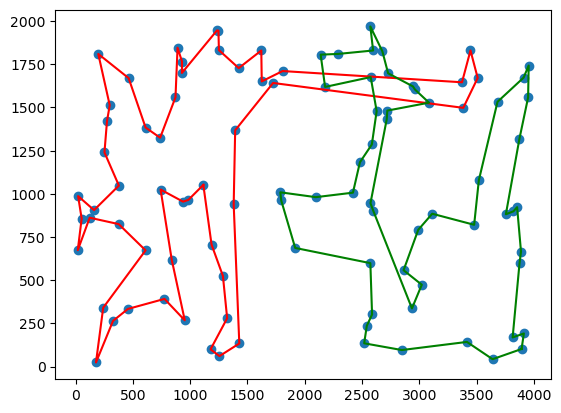

In [111]:
cycles = solve_cycle(distance_matrix)
print(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
plot_results(cycles)

Lowest distance = 26308.885271151106


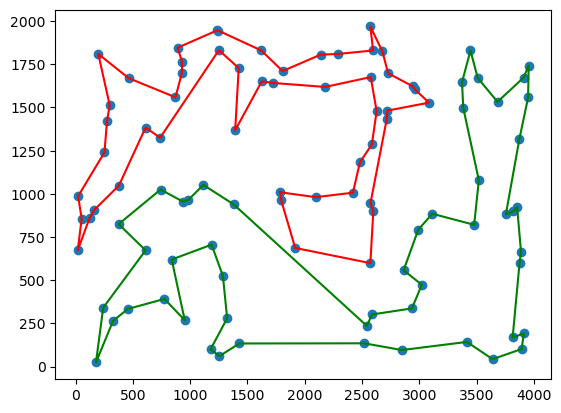

In [113]:
lowest_distance = np.inf
highest_distance = 0
sum_distance = 0
cycles = 0
for start in range(100):
    cycles = solve_cycle(distance_matrix)
    distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
    lowest_distance = min(lowest_distance, distance)
    if lowest_distance == distance:
        lowest_start = start
        best_cycles = [x.copy() for x in cycles]
print(f"Lowest distance = {lowest_distance}")
plot_results(best_cycles)

In [93]:
def shuffled_outside_swap_candidates(paths):
    arr = [[x,y] for x in range(len(paths[0])) for y in range(len(paths[1]))]
    random.shuffle(arr)
    return arr
def shuffled_inside_swap_candidates(path):
    arr = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            arr.append([i,j])
    random.shuffle(arr)
    return arr
def swap_vertice_cost(distance_matrix, path, index, new_city):
    path_length = len(path)
    previous = path[(index-1) % path_length]
    current = path[index]
    next = path[(index+1) % path_length]
    return distance_matrix[previous,new_city] + distance_matrix[new_city, next] - distance_matrix[previous, current] - distance_matrix[current, next]
def swap_vertice_outside_cost(distance_matrix, paths, i, j):
    return swap_vertice_cost(distance_matrix, paths[0], i, paths[1][j]) + swap_vertice_cost(distance_matrix, paths[1], j, paths[0][i])
def swap_vertice_inside_cost(distance_matrix, path, i, j): # can only use candidates from shuffled_inside_swap_candidates function
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    next1 = path[(i+1) % path_length]
    previous2 = path[(j-1) % path_length]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    if abs(i-j) == 1: # because if they are neighbours they can become each other next vertex in path, we also dont include distance between them in equation because it would be reduced anyway
        return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]
    if i in [0, path_length-1] and j in [0, path_length-1]:
        return distance_matrix[current2, next1] + distance_matrix[previous2, current1] - distance_matrix[current1, next1] - distance_matrix[previous2, current2]
    else:
        new_distance = distance_matrix[previous1, current2] + distance_matrix[current2, next1] + distance_matrix[previous2, current1] + distance_matrix[current1, next2]
        old_distance = distance_matrix[previous1, current1] + distance_matrix[current1, next1] + distance_matrix[previous2, current2] + distance_matrix[current2, next2]
        return new_distance - old_distance
def swap_edge_inside_cost(distance_matrix, path, i, j):
    if i == 0 or j == len(path) -1:
        return 0
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]
def swap_vertice_outside(paths, i, j):
    k = paths[1][j]
    paths[1][j] = paths[0][i]
    paths[0][i] = k
def swap_vertice_inside(path, i, j):
    k = path[j]
    path[j] = path[i]
    path[i] = k
def swap_edges_inside(path, i, j):
    path[i:j+1] = reversed(path[i:j+1])



[1, 4, 3, 2]


In [117]:
new_cycles = [x.copy() for x in best_cycles]
new_cycles[0].pop()
new_cycles[1].pop()
stop = False
while not stop:
    outside_swap_candidates = shuffled_outside_swap_candidates(new_cycles)
    stop = True
    for candidates in outside_swap_candidates:
        delta = swap_vertice_outside_cost(distance_matrix, new_cycles, candidates[0], candidates[1])
        if delta < 0:
            swap_vertice_outside(new_cycles, candidates[0], candidates[1])
            change_delta = delta
            swap_candidates = candidates.copy()
            stop = False
            action = "vertice outside"
            break
    if not stop:
        print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
        continue
    for i in range(len(new_cycles)):
        inside_swap_candidates = shuffled_inside_swap_candidates(new_cycles[i])
        for candidates in inside_swap_candidates:
            delta = swap_vertice_inside_cost(distance_matrix, new_cycles[i], candidates[0], candidates[1])
            if delta < 0:
                swap_vertice_inside(new_cycles[i], candidates[0], candidates[1])
                change_delta = delta
                swap_candidates = candidates.copy()
                stop = False
                action = "vertice inside"
                break
    if not stop:
        print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
        continue
    # for i in range(len(new_cycles)):
    #     inside_swap_candidates = shuffled_inside_swap_candidates(new_cycles[i])
    #     for candidates in inside_swap_candidates:
    #         delta = swap_edge_inside_cost(distance_matrix, new_cycles[i], candidates[0], candidates[1])
    #         if delta < -1e-10:
    #             swap_edges_inside(new_cycles[i], candidates[0], candidates[1])
    #             change_delta = delta
    #             swap_candidates = candidates.copy()
    #             stop = False
    #             action ="edge inside"
    #             break
    # if not stop:
    #     print(f" swap candidates = {swap_candidates} delta = {change_delta} swap = {action}")
    #     continue

 swap candidates = [18, 19] delta = -36.13492522343199 swap = vertice inside
 swap candidates = [48, 49] delta = -14.771386971939208 swap = vertice inside
 swap candidates = [0, 49] delta = -52.614829087988866 swap = vertice inside
 swap candidates = [43, 45] delta = -62.27872084321223 swap = vertice inside


In [118]:
new_cycles[0].append(new_cycles[0][0])
new_cycles[1].append(new_cycles[1][0])

distance = 25901.211931494392


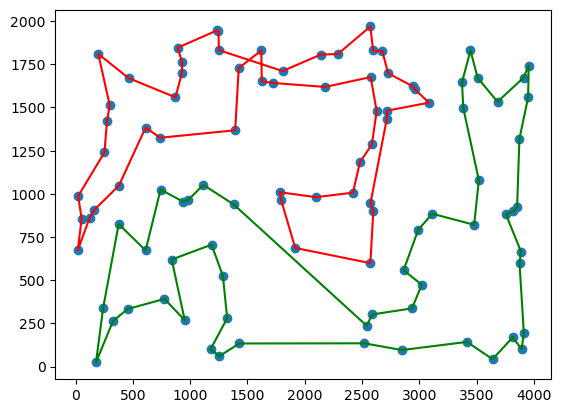

In [119]:
# new
distance = calc_distance_sum(new_cycles[0], distance_matrix) + calc_distance_sum(new_cycles[1], distance_matrix)
print(f"distance = {distance}")
plot_results(new_cycles)

distance = 29730.033662154532


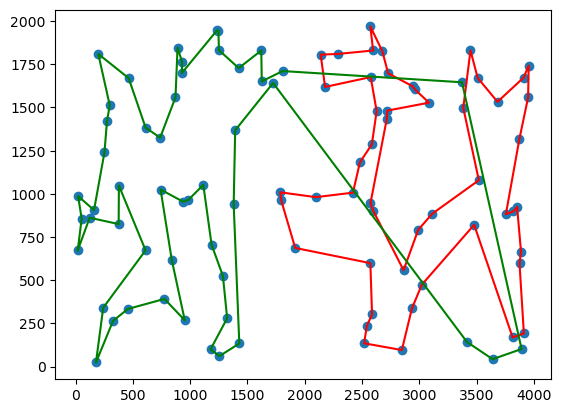

In [87]:
# old
distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
print(f"distance = {distance}")
plot_results(cycles)